# Composite Model Spectral Fitting

**Use case:** Fitting the complex continuum around Lyman-alpha in the spectrum of an active galaxy NGC 5548.<br>
**Data:** 3-column ECSV file with units for each column.<br>
**Tools:** specutils, numpy.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

## Introduction

In this example, we are fitting the complex continuum around Lyman-alpha in the spectrum of an active galaxy (NGC 5548). This involves a powerlaw, extinction, emission lines of various widths and absorption lines. Only certain regions of the spectrum (away from strong absorption lines) are fit. The model has some fixed and some free parameters, as well as parameters that are linked together. We are using the Astropy compound-model machinery to add fit all the components simultaneously. 

The example makes only partial use of specutils. It reads the data into the Spectrum1D data structure. However, when we get to actually fitting the model, we are just grabbing the numpy arrays (without units, because that caused some errors). 

#### Developer Notes
Todo: 
 
 - Move useful stuff from fit_functions upstream to astropy?
 - Use units and quantities all the way through
 - Illustrate fixing and freeing parameters
 - Illustrate locking and unlocking parameters
 - Figure out how to introspect the tied parameters (may need a helper class for Astropy modeling)
 - This model doesn't fit very well. Change the example. 
 - The covariance cell is returning nothing. Is that intended?
     - might be nice to show a triangle diagram of convariances

In [1]:
import numpy as np
import specutils
import time
import astropy.modeling.fitting as fitting
from astropy.table import Table, QTable
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from astropy.visualization import quantity_support

In [2]:
# import astropy
# import matplotlib
# print("Astropy Version: ",astropy.__version__)
# print("Numpy Version: ",np.__version__)
# print("Specutils Version: ",specutils.__version__)
# print("Matplotlib Version: ",matplotlib.__version__)

##### Developer notes: 

Versions:

 - Astropy Version:  5.3.3
 - Numpy Version:  1.25.2
 - Specutils Version:  1.11.0
 - Matplotlib Version:  3.7.2

In [3]:
import matplotlib.pyplot as plt
# inline -- noninteractive cells, notebook -- interactive cells 
%matplotlib inline 
# %matplotlib notebook
%config InlineBackend.figure_format ='retina' # Mackbook optimization

## Data input

 - spectrum: simple 3-column ECSV file with units for each column
 - wavelength regions to be included in fit: simple 2-column ASCII file with lower & upper bounds
 
First set up pathnames. 

##### Developer note

 - These data files are small ASCII files, so they are in the github repo with the notebook

In [4]:
datafile = "./n5548_mean_g130mb4.ecsv"
regionsfile = "./n5548_lyalpha_sample.dat"

Read the tables using astropy's QTable, so that we preserve the units.

#### Developer notes
It would be good if this example provided an example of recommended practice for encoding uncertainties in tables. Questions:

 - Should the uncertainties have units?
 - Seems like the name "uncertainty" is generally understood to mean standard deviation (or the equivalent). So if one wants to have these be, e.g., variance, the user should name the column `variance`. 
 - It's a bit ugly to have to either add a table column to make these an astropy uncertainty object, or just store that as as a separate variable.

In [5]:
data = QTable.read(datafile, format='ascii.ecsv')
data[:3]

wavelength,flux,uncertainty
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float64,float64,float64
1139.99559,4.39553486807e-14,1.12651909249e-15
1140.03439,4.15510398254e-14,1.09891679648e-15
1140.07320,4.31114724961e-14,1.12382203631e-15


## Put the spectrum into a Spectrum1D object

We need to convert the uncertainty into an astropy uncertainty object first.

##### Developer notes

I think it might be simpler to hide the uncertainty type as options to the Spectrum1D call, defaulting to standard-deviation. 

For example...I first tried what I thought would make sense:
```
    data['stdev'] = StdDevUncertainty(data['uncertainty'])
    spectrum = specutils.Spectrum1D(spectral_axis=data['wavelength']
                                ,flux=data['flux'],uncertainty=data['stdev'])
```
That raises an ```IncompatibleUncertaintiesException```.

In [6]:
uncertainty = StdDevUncertainty(data['uncertainty'])
spectrum = specutils.Spectrum1D(spectral_axis=data['wavelength'],
                                flux=data['flux'], uncertainty=uncertainty)
print(spectrum)

Spectrum1D (length=6058)
Flux=[4.39553487e-14 4.15510398e-14 4.31114725e-14 ... 4.29249682e-14
      4.32926834e-14 4.29053909e-14] erg / (Angstrom s cm2),  mean=0.00000 erg / (Angstrom s cm2)
Spectral Axis=[1139.99559 1140.03439 1140.0732  ... 1374.93642 1374.97522
               1375.01402] Angstrom,  mean=1257.50481 Angstrom
Uncertainty=StdDevUncertainty ([1.12651909e-15 1.09891680e-15 1.12382204e-15 ... 6.80353568e-16
 6.85057505e-16 6.81109860e-16] erg / (Angstrom s cm2))


## Read in the spectral regions

Convert these into specutils SpectralRegions. 

In [7]:
regionstab = QTable.read(regionsfile,format='ascii')
subregions = []
for x0,x1 in zip(regionstab['col1'],regionstab['col2']):
    subregions += [(x0*u.AA, x1*u.AA)]
regions=specutils.SpectralRegion(subregions)
regions

Spectral Region, 24 sub-regions:
  (1145.83 Angstrom, 1151.33 Angstrom) 
  (1152.88 Angstrom, 1187.88 Angstrom) 
  (1193.68 Angstrom, 1197.7 Angstrom)  
  (1197.3 Angstrom, 1198.53 Angstrom)  
  (1201.38 Angstrom, 1205.38 Angstrom) 
  (1207.08 Angstrom, 1208.36 Angstrom) 
  (1210.58 Angstrom, 1213.58 Angstrom) 
  (1217.38 Angstrom, 1218.75 Angstrom) 
  (1220.3 Angstrom, 1221.7 Angstrom)   
  (1223.02 Angstrom, 1224.08 Angstrom) 
  (1225.74 Angstrom, 1227.2 Angstrom)  
  (1227.86 Angstrom, 1228.35 Angstrom) 
  (1229.08 Angstrom, 1230.38 Angstrom) 
  (1236.68 Angstrom, 1238.0 Angstrom)  
  (1238.95 Angstrom, 1239.53 Angstrom) 
  (1240.42 Angstrom, 1242.24 Angstrom) 
  (1242.93 Angstrom, 1249.88 Angstrom) 
  (1250.68 Angstrom, 1253.17 Angstrom) 
  (1254.04 Angstrom, 1254.32 Angstrom) 
  (1256.36 Angstrom, 1256.47 Angstrom) 
  (1263.37 Angstrom, 1263.64 Angstrom) 
  (1264.28 Angstrom, 1270.0 Angstrom)  
  (1362.51 Angstrom, 1369.56 Angstrom) 
  (1370.15 Angstrom, 1372.76 Angstrom) 

## Create a mask from the regions

##### Developer note
We could probably do the whole workflow extracting regions, but I think it would end up being uglier than using a mask.

In [8]:
def mask_from_regions(spectrum,regions):
    mask = np.zeros(spectrum.spectral_axis.shape,dtype=np.bool_)
    for r in regions:
        submask = (spectrum.spectral_axis>r.lower) & (spectrum.spectral_axis<=r.upper)
        mask = mask | submask
    spectrum.mask = mask

In [9]:
mask_from_regions(spectrum,regions)
print(spectrum.mask.min(), spectrum.mask.max())

False True


## Convenience routine for plotting a spectrum and highlighting the mask

##### Developer notes
 
 - I think this way of illustrating the mask is reasonably elegant. I sort of like it better than having the shaded regions extend all the way up to the top. (I do that later when showing the residuals, for comparison).
 - Another way to do it might be to change the line color to grey, or change the opacity, in the masked regions, but that would be harder to implement and probably slower.
 - This routine exposes both a benefit of using units and Spectrum1D -- you can automatically put the units on the axis
 - This also exposes a limitation: Right now, while quantity_support() puts the units on the axis automaticall, it doesn't put the label. It is the standard convention to give `label (units)` when labeling axes. The trick used here of adding in the label using `get_label()` and `set_label()` is liable to be too obscure for most users. 
 - Are we going to keep all visualization for specviz, or should there be some tools for visualization in specutils?

In [10]:
def plot_spectrum(spectrum,color='b',alpha=0.5,figsize=(15,6),
                  label=None,ax=None,plot_mask=True,
                  mask_color='g',mask_alpha=0.1,title=None):
    with quantity_support():
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.plot(spectrum.spectral_axis,spectrum.flux,color=color,alpha=alpha,label=label)
        if plot_mask: 
            if spectrum.mask is not None:
                ax.fill_between(spectrum.spectral_axis,0,spectrum.flux*spectrum.mask,
                        alpha=mask_alpha,color=mask_color)
    ax.set_xlabel(r"Wavelength (" + ax.get_xlabel() + ")")
    ax.set_ylabel(r"Flux (" + ax.get_ylabel() + ")")
    return ax

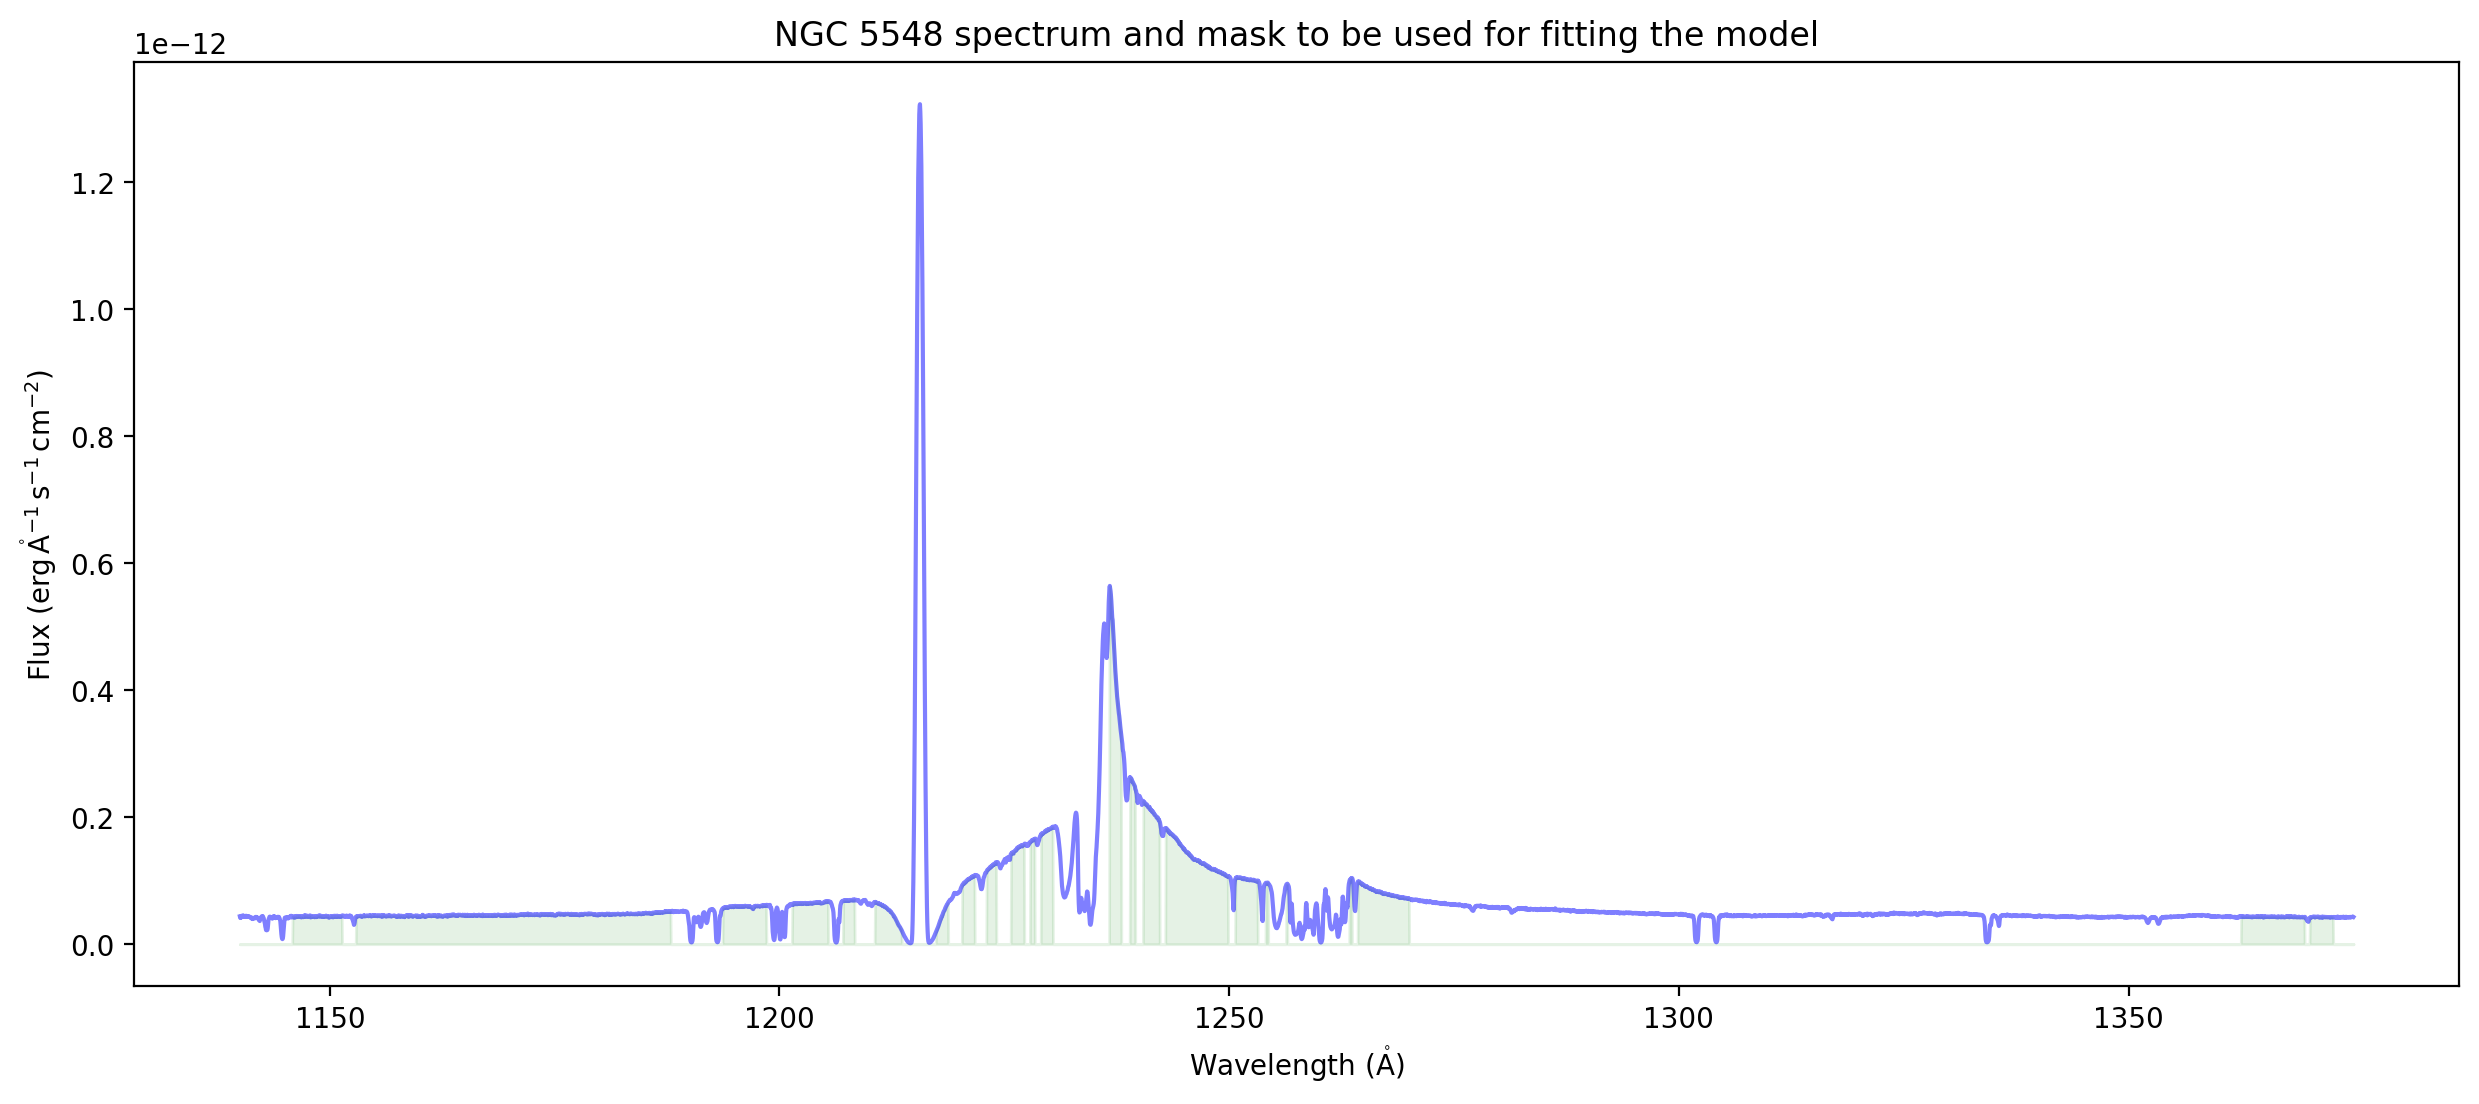

In [11]:
ax = plot_spectrum(spectrum)
ax.set_title('NGC 5548 spectrum and mask to be used for fitting the model');

<h1>First guess model</h1>

The model is imported directly:

In [12]:
import n5548_models as models

The .py module defined above builds one or more instances of a special type of function defined in the astropy.modeling.models package, called a "compound model". 

A compound model is just a combination of astropy.modeling.models functions, using as combination operators such things as addition, multiplication, and others.

Example: 

<code>compound_model = models.PowerLaw1D(1.,1.) + models.Gaussian1D(1.,1.,1.)</code>

will create an instance of a compound model with two components.

An actual, importable model definition will look like this:

```python
from custom_models import gaussian, powerlaw, ccmext

model1 = \
    powerlaw(name = 'powerlaw1',
             amp =   6.586200E-14,
             x_0 =   1000.0,
             alpha = 0.4819233,
             bounds = {'amp':   (0., 1.00E-11),
                       'x_0':   (0., 1.00E-11),
                       'alpha': (-5., 5.)},
             fixed = {'x_0': True}
             ) \
+ \
    gaussian(name = 'C III 1176',
             norm = 2.000000E-14,
             mean = 1195.006,
             fwhm = 861.4926,
             bounds = {'norm': (0., 1.00E-10),
                       'mean': (1000., 2000.),
                       'fwhm': (1000., 2000.),
                       'skew': (1., 1.)},
             fixed = {'norm': True,
                      'mean': True,
                      'fwhm': True,
                      'skew': True},
             ) \
```             


For this exercise, we pick the model named 'model1':

In [13]:
compound_model = models.model1

The module uses some special function types, defined by overriding the standard functions in asytropy.modeling.models in module custom_models. 

This overriding is necessary because the spectral components in specfit do not conform with the standards defined in astropy.modeling.models. For example, a Gaussian in specfit is defined by an amplitude, a central wavelength, a FWHM in km/s, and a skweness parameter. In astropy.modeling.models a Gaussian is defined by an amplitude, a central wavelength, and a width in units consistent with the units of the central wavelength. And no skewness parameter. These incompatibilities are addressed by the sub-classes defined in the fit_functions module. 

##### Developer notes

 - Seems useful to have a Gaussian with skew as an Astropy model, so that should probably be moved upstream.
 - Not sure about the FWHM. It's probably cleaner for that to be the width parameter when there is skewness, since it's more intuitive than standard deviation.
 - The print statement for the compound model below is okay but not great. Might be worth having a pretty print for notebooks that makes this more readable.
   - This print statement does not indicate which parameters are fixed or floating
   - It does not indicate which parameters are tied to others and how
   - There is an ellipsis in the table at the end

In [14]:
print(compound_model)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=0.4819233, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.01713, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew=1.,

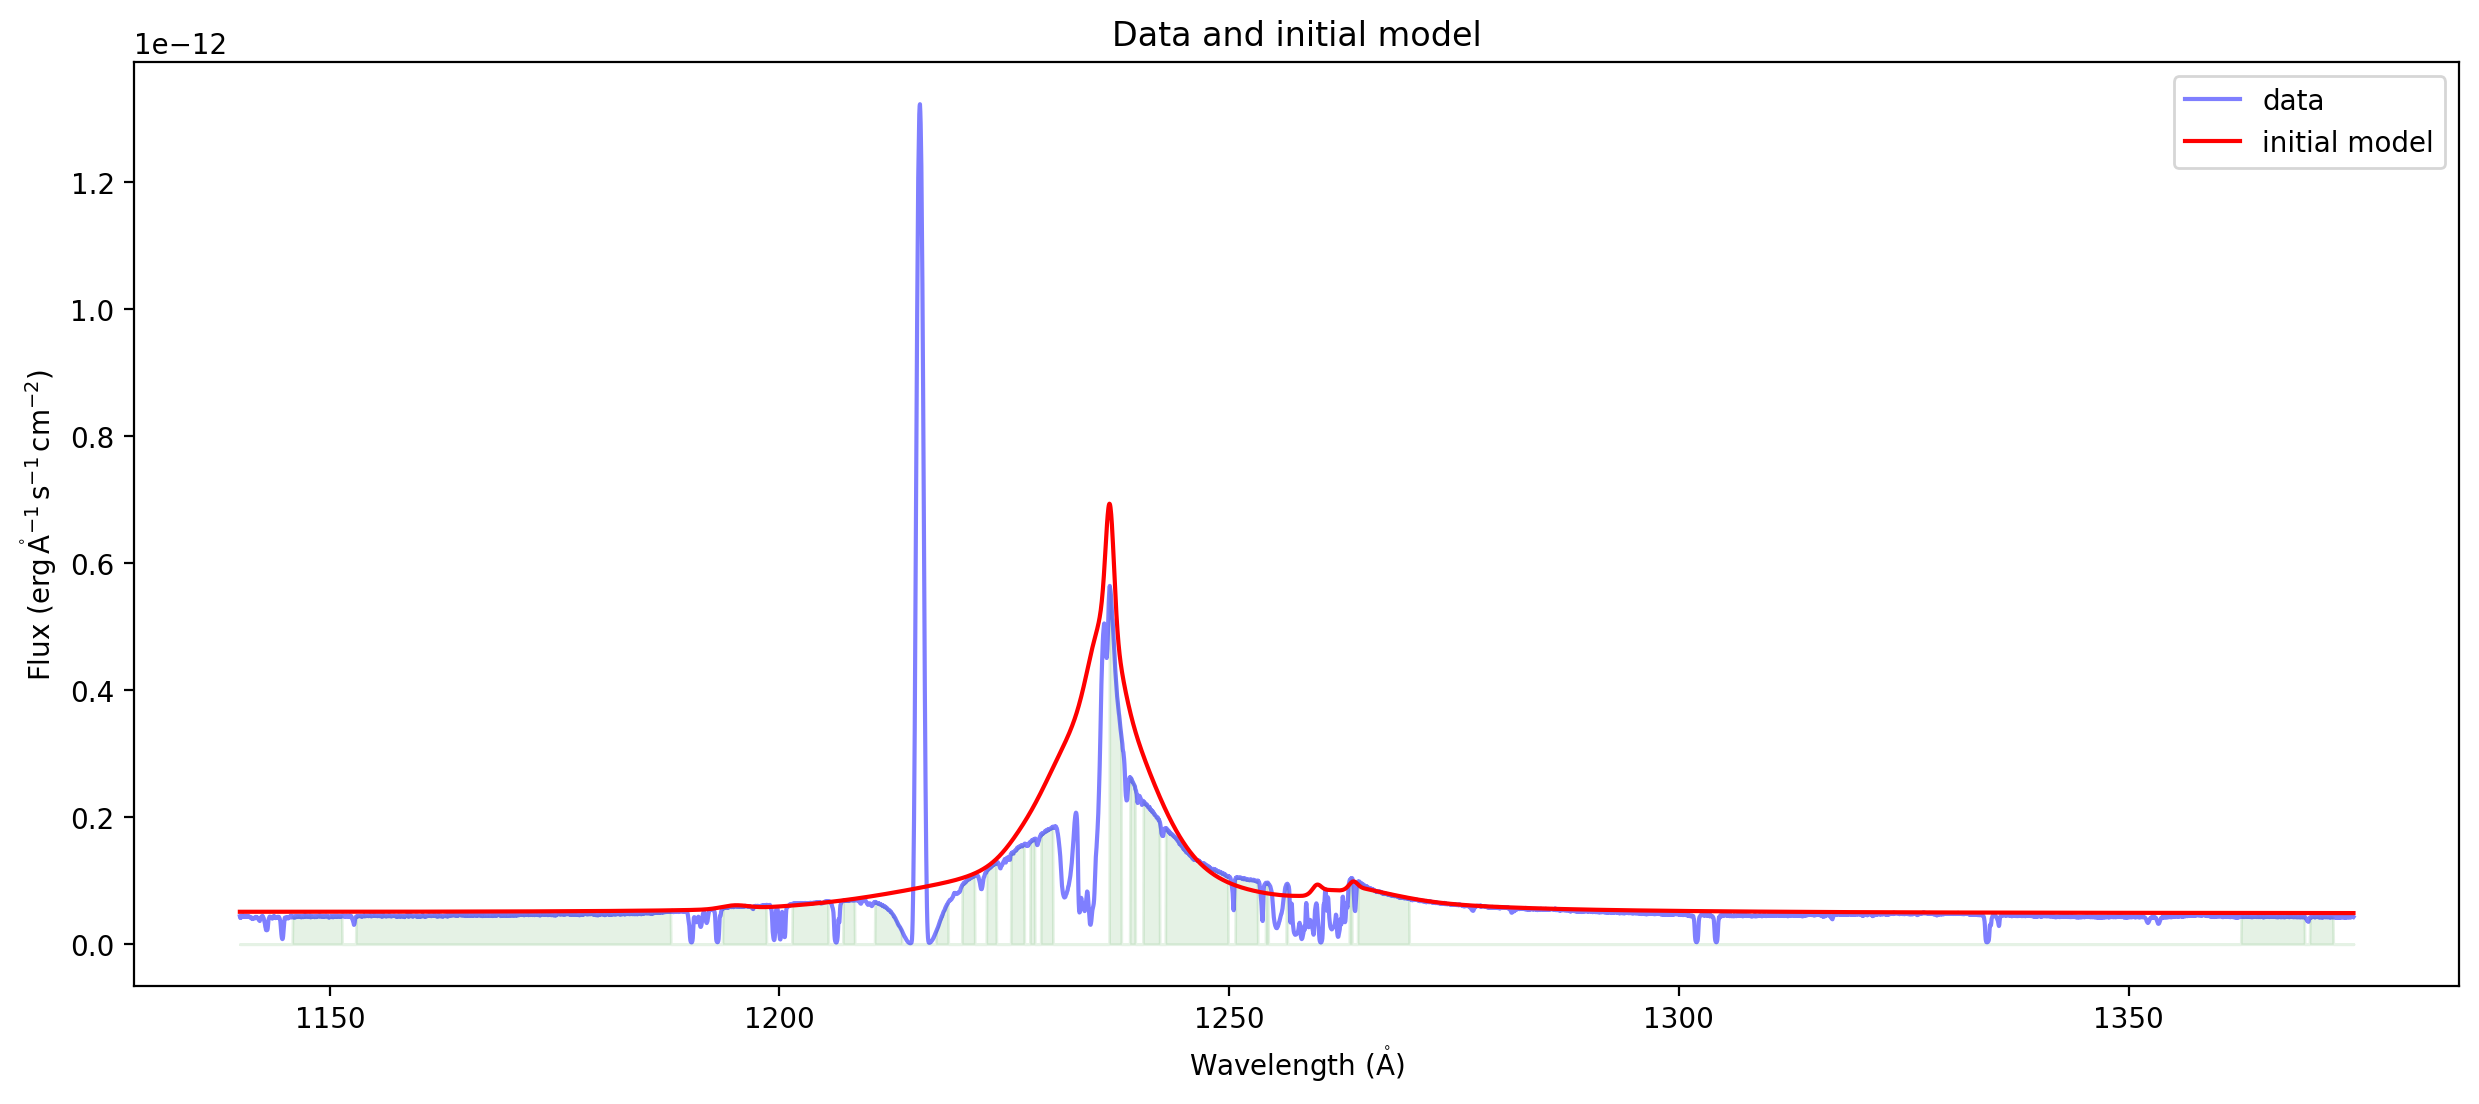

In [15]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(spectrum.spectral_axis, compound_model(spectrum.spectral_axis.value), 'r',label='initial model')
ax.legend()
ax.set_title("Data and initial model");

# Fitting

We have the data and the model, now we need to fit one to the other. We can use that by instantiating an Astropy fitter, in this case the `LevMarLSQFitter` which uses the Levenberg-Marquardt algorithm for least-squares fitting. 

In [16]:
fitter = fitting.LevMarLSQFitter()

In this example, we have access to the errors for the data points, so we can use their inverse as weights for the fit. To include the mask, which is `1` for pixels we want to fit and `0` for pixels we want to exclude, we take $\rm {mask} / \sigma$, as the weight to give to the fitter.

##### Developer notes

 - Because the compound model fitting didn't work out of the box feeding it the Specutils `spectral_axis` and `flux` Quanitities, I'm getting rid of the units. In conversation, it seems like there is some machinery for removing the units and putting them back in `fit_line` (which is more general than just fitting a line), but I didn't think to look there.
 - While it agrees with the scipy fitter conventions, I think it is quite confusing to call $w = 1/\sigma$ the *weight*. I checked the code and for this fitter, indeed it is squaring this to use as the weight, so the calculation is correct. But I think it is more common to think of the correct weight as being $w = 1/\sigma^2$ for least-squares fitting. I've now gone down the rabbit hole of trying to double-check that Astropy is doing the weighting correctly twice because of this unusual use of the word "weight."
 - Nadia Dencheva is going to check that the non-least-squares fitters are using weight when their instructions say use $1/\sigma$ -- i.e. are they squaring it or not before computing the merit function?

In [17]:
wavelength = spectrum.spectral_axis.value
flux = spectrum.flux.value
inverse_sigma = spectrum.mask/spectrum.uncertainty.array

To do the fit, call the fitter instance with the data, weights, and some control parameters if needed. Let's do some timing as well:

In [18]:
start_time = time.time()
fit_result = fitter(compound_model, wavelength, flux, weights=inverse_sigma, acc=1.E-30, maxiter=6000)
end_time = time.time()
print("Elapsed time: ", end_time - start_time)

Elapsed time:  4.477346897125244


##### Developer note

 - I'm not sure how to interpret the fit_info message below that 
 
 ```Both actual and predicted relative reductions in the sum of squares
  are at most 0.0000001```

In [19]:
print(fitter.fit_info['message'])

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000


The result is another instance of a compound model, with the fitted values set into the  parameter values:

In [20]:
print(fit_result)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] * [1] + [2] + [3] + [4] + [5] + [6] + [7] + [8] + [9] + [10] + [11] + [12] + [13] + [14] + [15] + [16] + [17] + [18] + [19] + [20] + [21]
Components: 
    [0]: <powerlaw(amplitude=0., x_0=1000., alpha=1.54483037, name='powerlaw1')>

    [1]: <ccmext(ebmv=0.07957306, rv=3.1, name='extinction')>

    [2]: <gaussian(norm=0., mean=1195.006, fwhm=861.4926, skew=1., name='C III 1176')>

    [3]: <gaussian(norm=0., mean=1226.392, fwhm=861.4926, skew=1., name='Si III 1206')>

    [4]: <gaussian(norm=0., mean=1236.729, fwhm=255.4998, skew=1., name='Ly alpha - NLR, ILR,  medium,  very broad')>

    [5]: <gaussian(norm=0., mean=1235.996, fwhm=861.4926, skew=1., name='gaussian5')>

    [6]: <gaussian(norm=0., mean=1235.138, fwhm=3040.59, skew=1., name='gaussian6')>

    [7]: <gaussian(norm=0., mean=1231.589, fwhm=8133.099, skew=1., name='gaussian7')>

    [8]: <gaussian(norm=0., mean=1237.643, fwhm=18183.71, skew

Lets print some derived results:

# Looking at the fit results

Create a little routine to estimate chisq. It needs to compute the number of degrees of freedom taking into account the mask and the number of free parameters.

In [21]:
def chisq(x, y, err, mask, model, nfree):
    chisq = (y - model(x))**2 / err**2
    chisq = np.sum(chisq * mask)
    npoints = np.sum(mask)
    return np.sqrt(chisq / (npoints - nfree - 1)) 

Figure out how many fixed and free parameters there are.

##### Developer note

 - This is pretty ugly and involved. The fitter knows how many data points and free parameters there are, but I don't think it passes that information along as "metadata" to the fit results. The fit_info is a dictionary returned from `scipy.optimize.leastsq`, but it doesn't have the number of free parameters.

In [22]:
if 'fixed' in fit_result.parameter_constraints:
    fix = np.asarray(fit_result.fixed.values())
    n_fixed_parameters = np.sum(np.where(fix, 1, 0))
else:
    n_fixed_parameters = 0

if 'tied' in fit_result.parameter_constraints:
    tie = np.asarray(fit_result.tied.values())
    n_tied_parameters = np.sum(np.where(tie, 1, 0))
else:
    n_tied_parameters = 0
    
n_free_par = len(fit_result.parameters) - n_fixed_parameters - n_tied_parameters

Print out $\chi^2$ and other relevant info.

##### Developer note
 - This kind of thing ought to be standard output

In [23]:
chisq_in = chisq(wavelength, flux, spectrum.uncertainty.array, spectrum.mask, compound_model, n_free_par)
chisq_out = chisq(wavelength, flux, spectrum.uncertainty.array, spectrum.mask, fit_result, n_free_par)
print("chisq from input model:  %f" % chisq_in)
print("chisq from output model: %f" % chisq_out)
print("Total data points: %d" % len(wavelength))
print("Data points in wavelength ranges: %d" % np.sum(spectrum.mask))
print("Number of free parameters: %d" % n_free_par)
print("Number of iterations: %d" % fitter.fit_info['nfev'])
print ("Fit engine took %d elapsed seconds." % (end_time - start_time))

chisq from input model:  19.531387
chisq from output model: 10.393380
Total data points: 6058
Data points in wavelength ranges: 2318
Number of free parameters: 83
Number of iterations: 596
Fit engine took 4 elapsed seconds.


Errors associated with each free parameter from the covariance matrix.

##### Developer note

 - This is empty. But it actually is in the fit_info from this fitter, so we could grab it.
 - It would be nice in a more advanced version of this notebook to show someone how to plot the error ellipses in a triangle (corner) plot, which is a good way to visualize correlations between pairs of parameters.

In [24]:
cov = fitter.fit_info['param_cov']

param_errors = {}
i = 0
if cov is not None:
    # extract variances from covariance matrix
    fit_errors = {}
    for param_name in fit_result.param_names:
        fixed = fit_result.fixed[param_name]
        tied = fit_result.tied[param_name]
        if not fixed and not tied:
            fit_errors[param_name] = math.sqrt(cov[i,i])
            i += 1
            
    # map errors to input model's components and parameters.
    for param_name in fit_errors.keys():
        index, target_param_name = fit_result._param_map[param_name]
        component_name = fit_result._submodels_names[index]
        param_errors[(component_name, target_param_name)] = fit_errors[param_name]

print(param_errors)

{}


<h1>Plots</h1>

## Input and output compound models

##### Developer notes
 - A fancy, but *very* useful interactive version of this plot might have the following features
   - Zoom & pan, etc (could get that by using %matplotlib notebook, but scrolling is a pain with that) 
   - Ability to toggle from curves to histograms for the data
   - Ability to toggle on and off the mask, change alpha, etc
   - Ability to toggle on and off errorbars on the data, change alpha, etc
   - Hover information: data, residual, percent contribution to chisq for that one point
   - Ability to toggle on and off individual components of the compound model
      - That wouldn't be all that useful in this example, since it's better to see them on top of the powerlaw*extinction, but that's a pretty special use case.

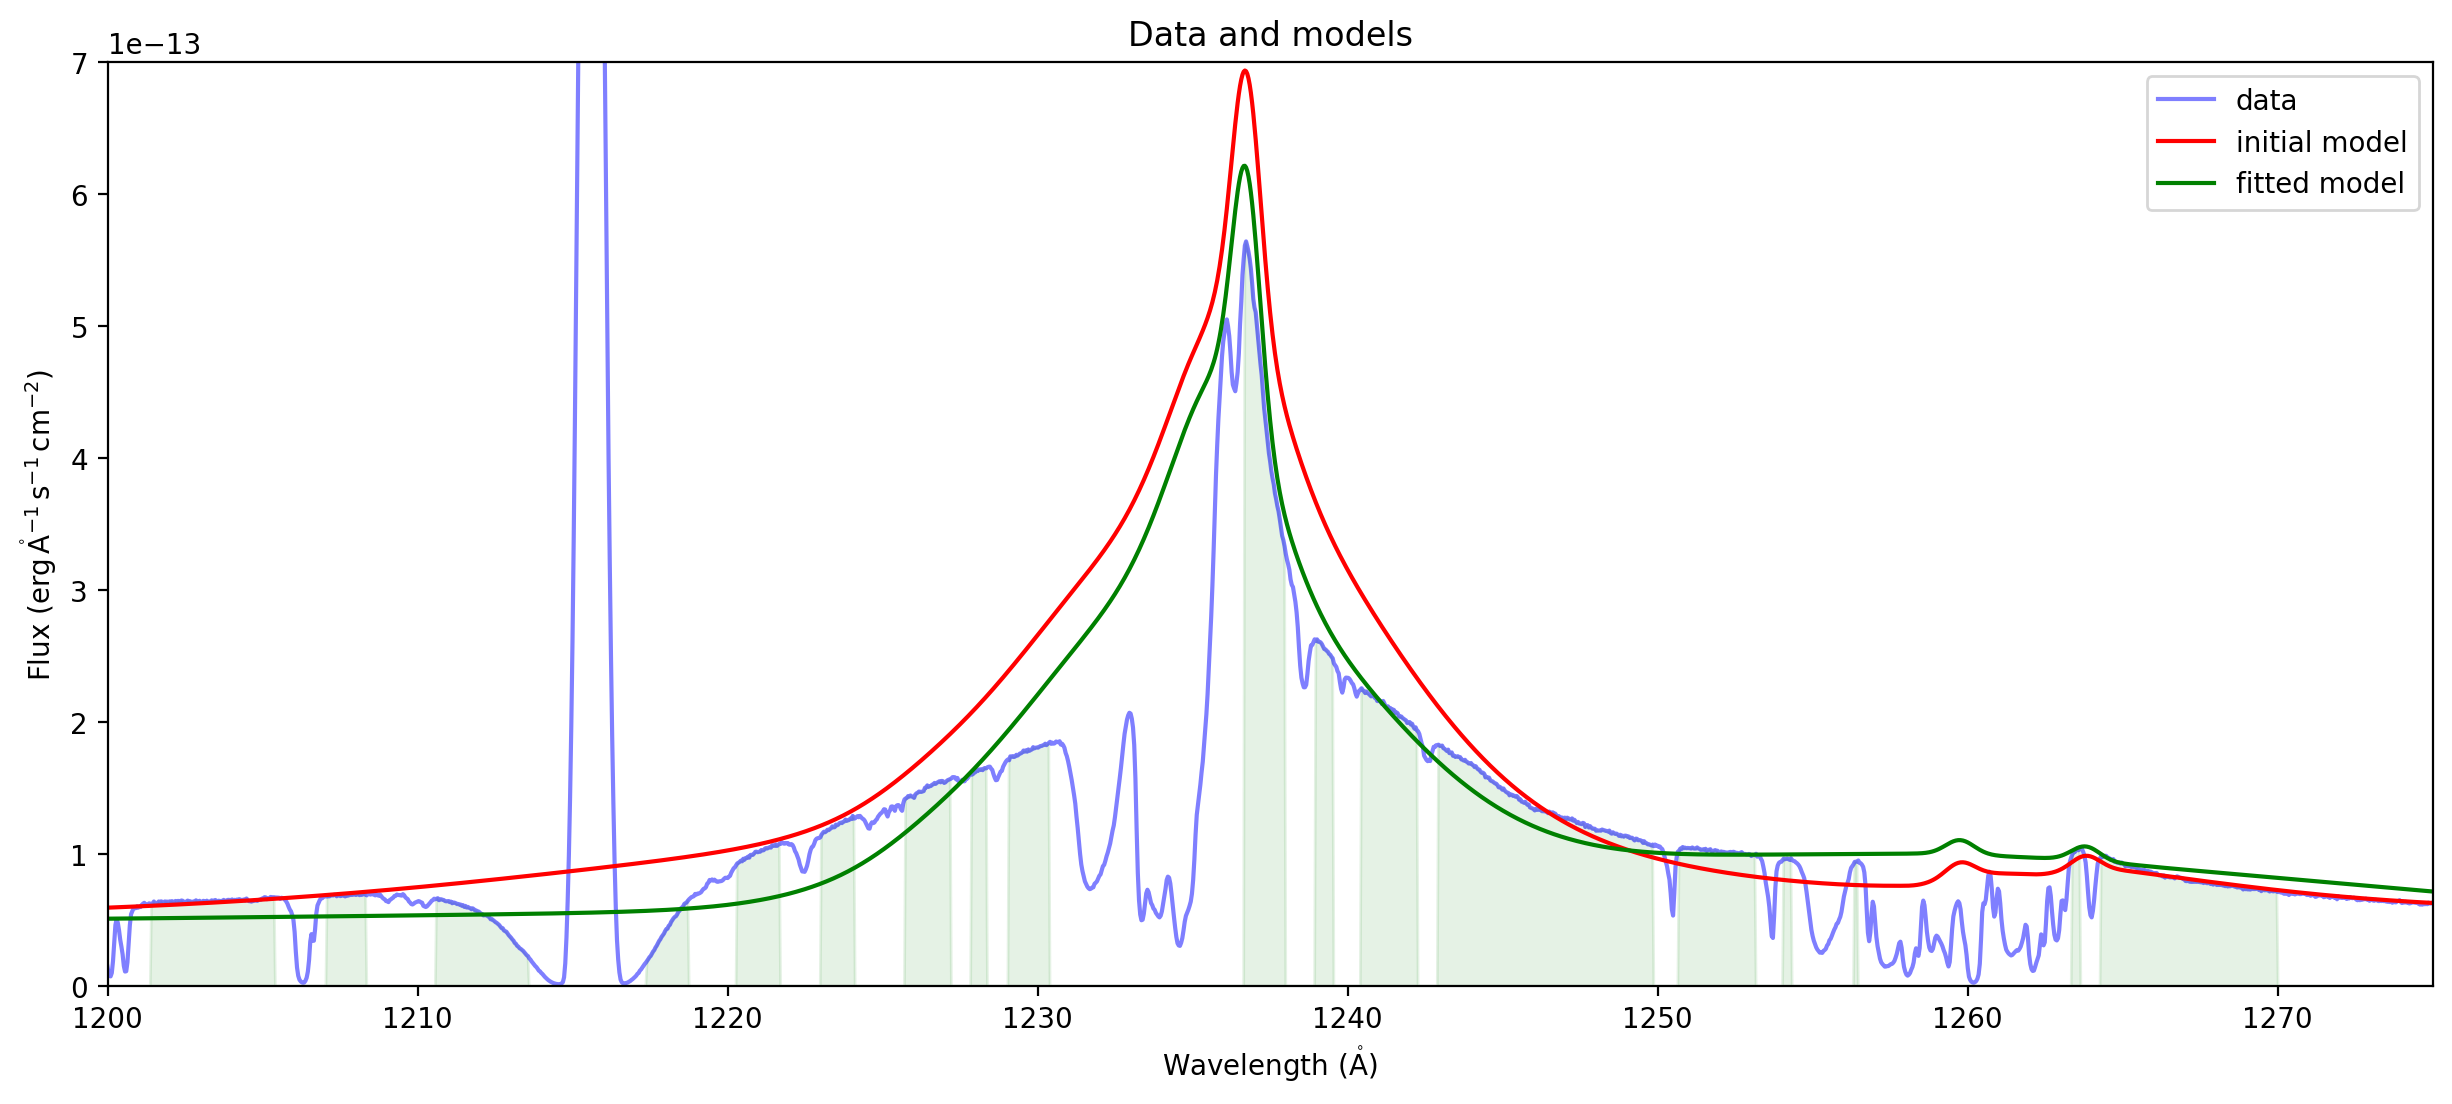

In [25]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(wavelength, compound_model(wavelength), 'r',label='initial model')
ax.plot(wavelength, fit_result(wavelength), 'g',label='fitted model')
ax.set_xlim((1200,1275))
ax.set_ylim((0,7e-13))
ax.legend()
ax.set_title("Data and models");

## Plot the residuals

Focus in on the most interesting region. 

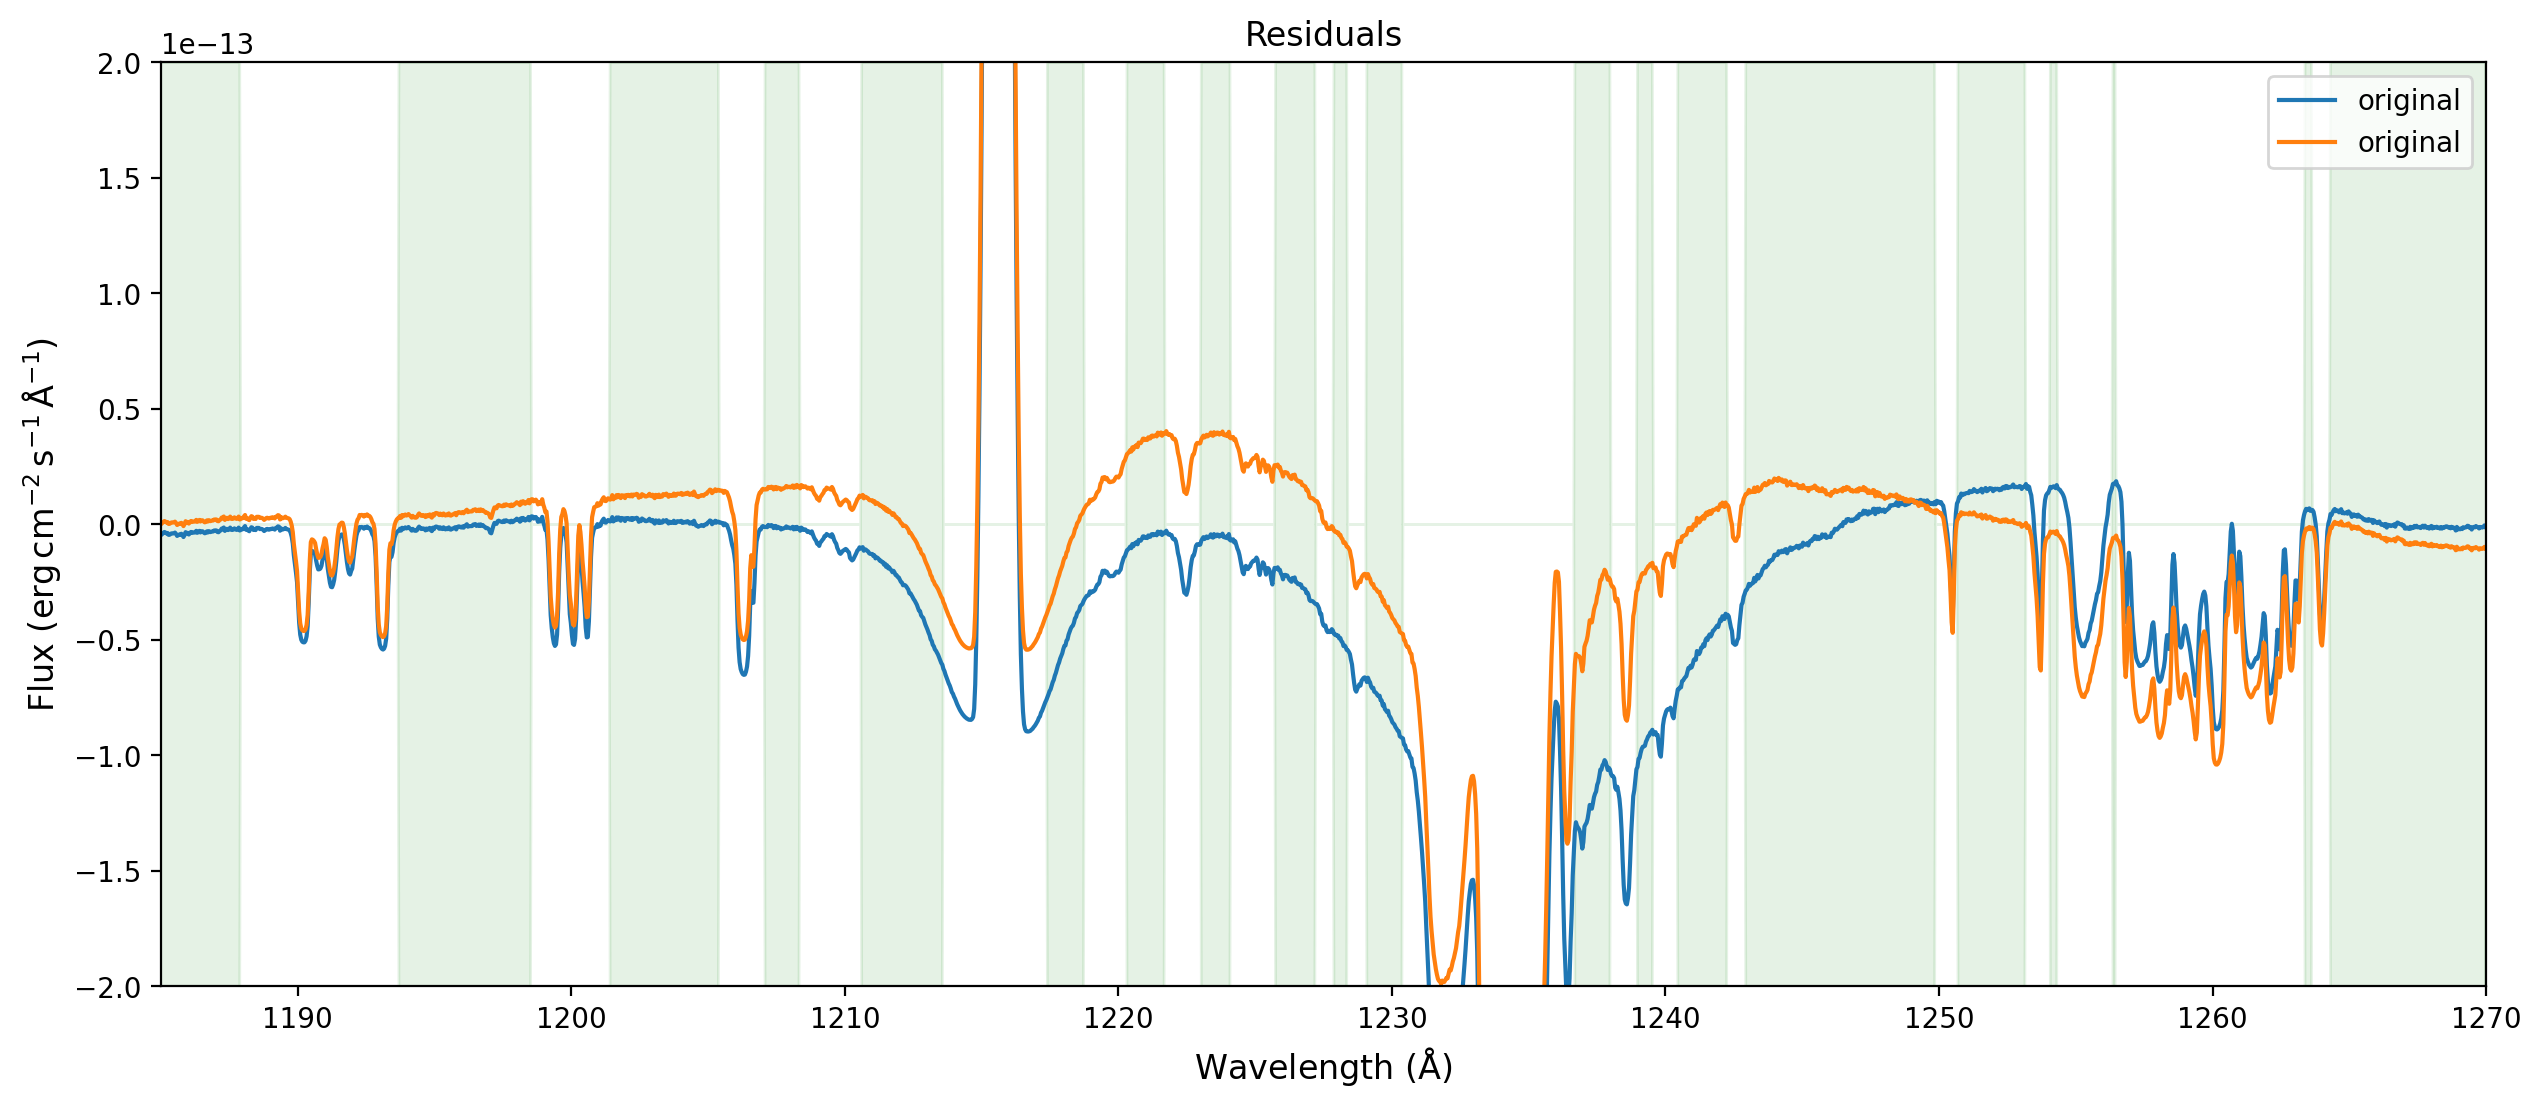

In [26]:
ylim = (-2.e-13, 2.e-13)
fig,ax = plt.subplots(figsize=(15,6))
ax.plot(wavelength,flux-compound_model(wavelength),label='original')
ax.plot(wavelength,flux-fit_result(wavelength),label='original')
ax.fill_between(wavelength,ylim[0]*spectrum.mask,ylim[1]*spectrum.mask,
                        alpha=0.1,color='g')
ax.set_xlim((1185., 1270.))
ax.set_ylim(ylim)
ax.legend()
ax.set_xlabel(r'Wavelength ($\rm \AA$)',fontsize='large')
ax.set_ylabel(r'Flux ($\rm erg\, cm^{-2}\, s^{-1}\, \AA^{-1}$)',fontsize='large')
ax.set_title('Residuals',fontsize='large');

## Plot individual components

Here we plot them on top of the basic powerlaw*extinction 

##### Developer notes

 - I was trying to label or otherwise indicate which ones are tied together, but it seems like this information gets lost because because tying parameters is just done by passing a function. It might be better for Astropy to have a base class that people can use that would have the name of the referenced parameter as an attribute and has a `__call__` method. Then one could at least recommend that people use this when tying parameters, to facilitate later introspection.

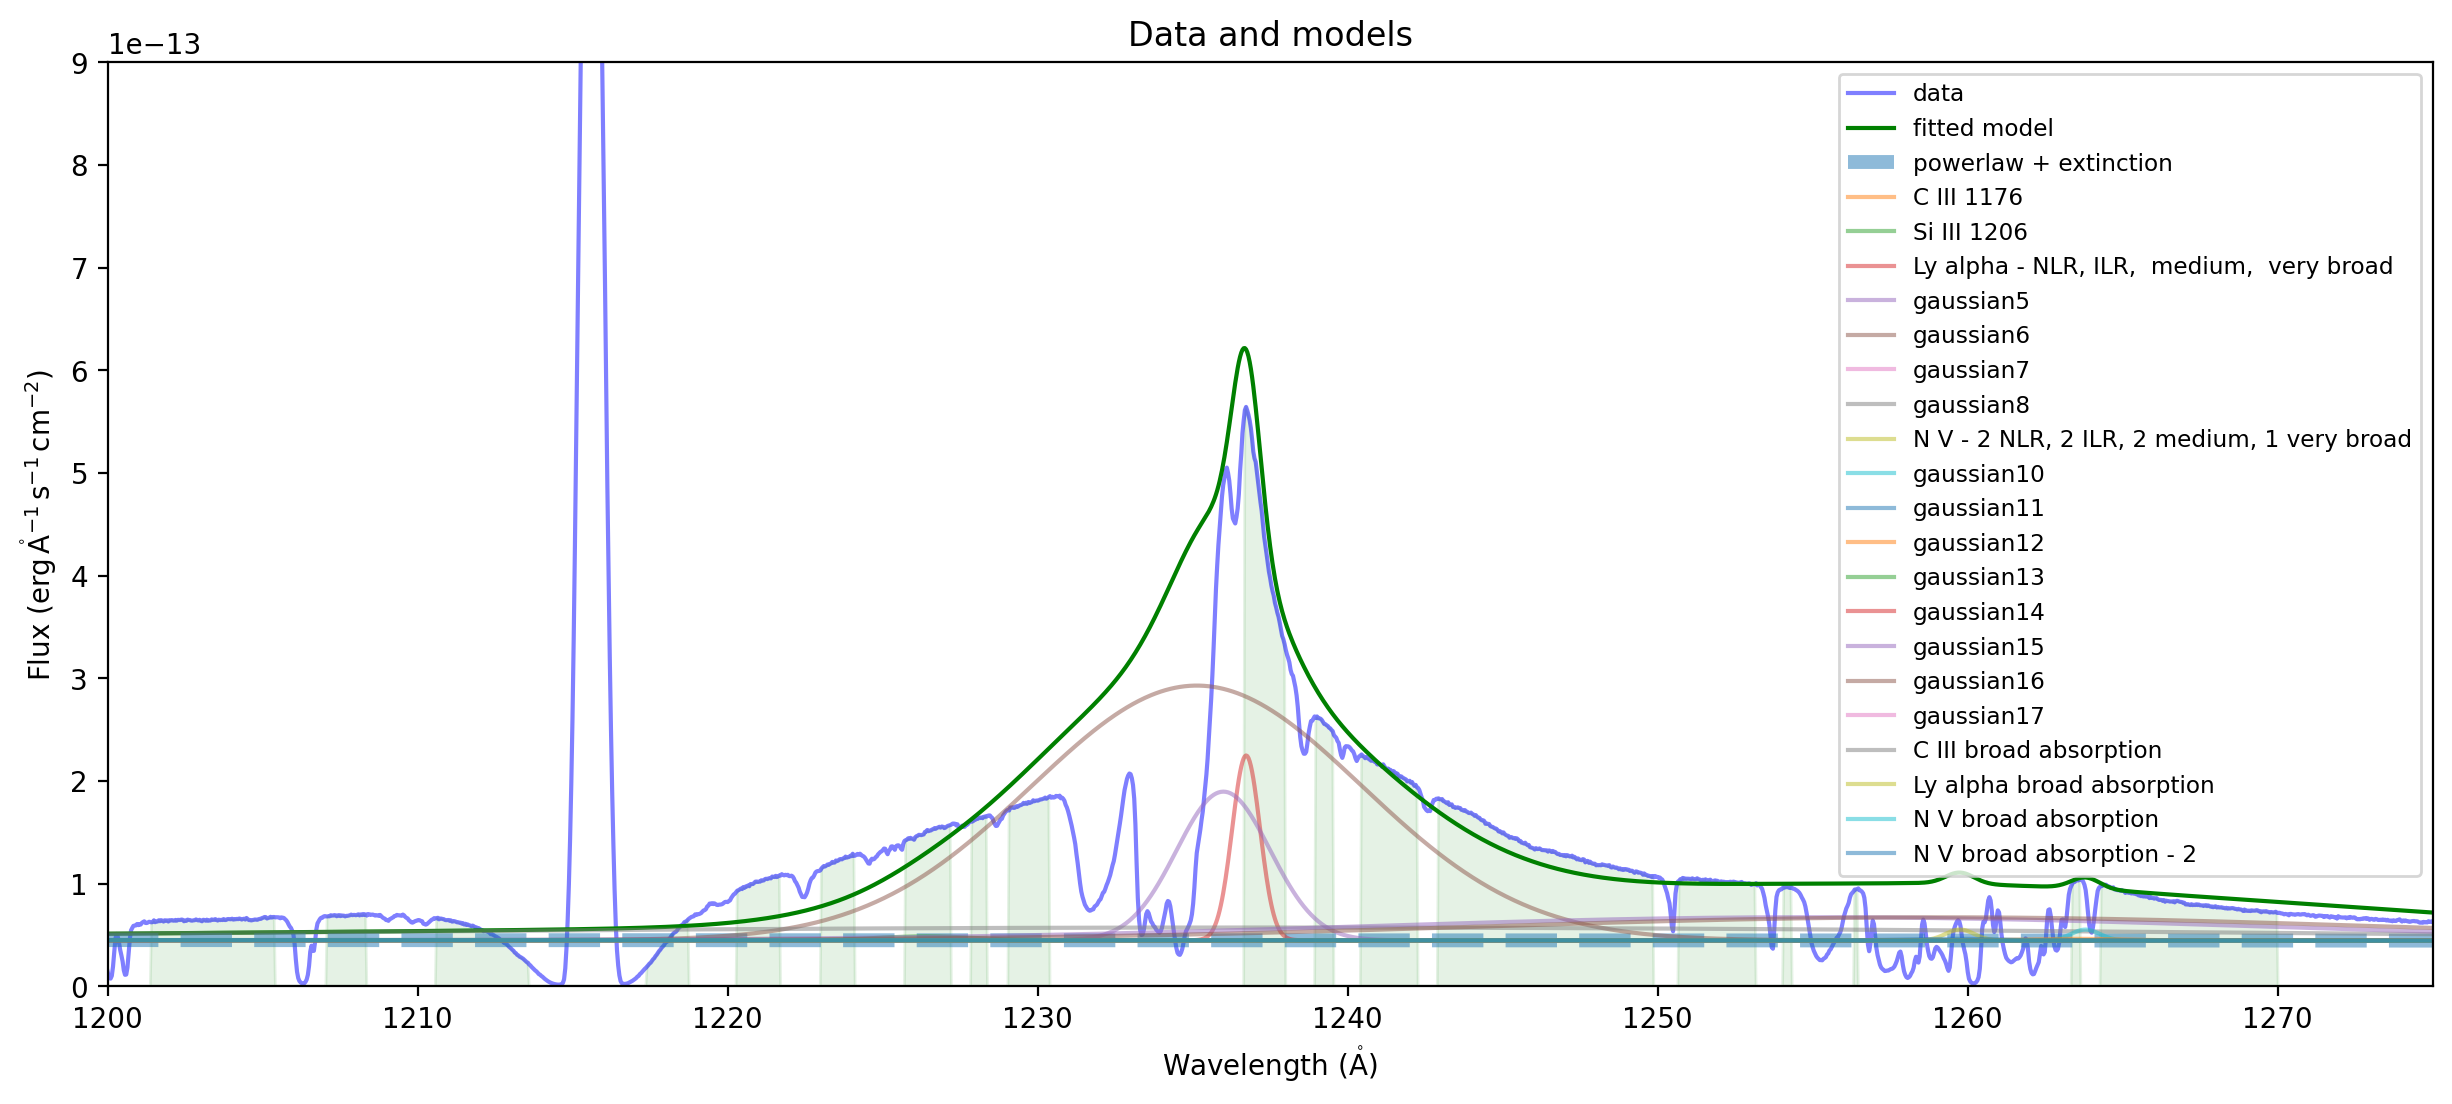

In [27]:
ax = plot_spectrum(spectrum,label='data')
ax.plot(wavelength, fit_result(wavelength), 'g',label='fitted model')
plext = fit_result['powerlaw1'] * fit_result['extinction']
ax.plot(wavelength,plext(wavelength),'--',alpha=0.5,linewidth=5,label="powerlaw + extinction")
for component in fit_result:
    if component.name != 'powerlaw1' and component.name != 'extinction':
        ax.plot(wavelength,(plext+component)(wavelength),label=component.name,alpha=0.5)
ax.set_xlim((1200,1275))
ax.set_ylim((0,9e-13))
ax.legend(loc='upper right',fontsize='small')
ax.set_title("Data and models");